# UMAPs Neurips samples, NK cells

In this notebook UMAPs are generated from latent space, CLR transformed protein counts and RNA expression to compare the clustering results. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scvi
import scanpy as sc
import umap

from ridgeplot import ridgeplot
from pySankey import sankey

import warnings

warnings.filterwarnings('ignore')



Global seed set to 0
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


# 1. Preparations

In [2]:
#Neurips

adata = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_neurips_norm_outer.h5ad')

In [3]:
adata.var_names.str.startswith('MT-')

array([False, False, False, ..., False, False, False])

In [4]:
adata = adata.copy()

In [5]:
#Selecting only one sample

adata =adata[adata.obs['POOL'] == "s4d1"]

In [6]:
adata.shape

(4885, 21720)

In [7]:
#protein information saved

adata_prot=adata.obsm['protein_expression_clr_neurips']

In [8]:
df = adata_prot

In [9]:
df=adata.obsm['protein_expression_clr_neurips'].astype(float)

In [10]:
#empty anndata file with correct shape (for protein data)

adata_new_prot = ad.AnnData(np.random.poisson(1, size=(4885, 139)))

In [11]:
#adata file where X = CLR normalized protein 
adata_new_prot.X=df

In [12]:
#obs and var names identified

adata_new_prot.obs_names = df.index
adata_new_prot.var_names = df.columns

In [13]:
adata_new_prot

AnnData object with n_obs × n_vars = 4885 × 139

In [14]:
#RNA expression to df

df_rna = adata.to_df()

In [15]:
#selecting nonzero columns (at least some expression detected), these are removed next

nonzero = df_rna.columns[(~(df_rna == 0)).sum() != 0]

In [16]:
#RNA data (zero columns removed) is added to obs 

df_rna=adata.to_df().loc[:,nonzero]

In [17]:
df_rna.shape

(4885, 13906)

In [18]:
#empty anndata file with correct shape (for RNA data)

adata_new_rna = ad.AnnData(np.random.poisson(1, size=(4885, 13906)))

In [19]:
#adata file where X = RNA expression

adata_new_rna.X=df_rna

In [20]:
#obs and var names identified

adata_new_rna.obs_names = df_rna.index
adata_new_rna.var_names = df_rna.columns

In [21]:
adata_new_rna

AnnData object with n_obs × n_vars = 4885 × 13906

In [22]:
import muon as mu

In [23]:
#Combine previous two adata files into one muon object

mdata = mu.MuData({'rna': adata_new_rna, 'adt': adata_new_prot})

In [24]:
mdata.obsm

MuAxisArrays with keys: rna, adt

In [25]:
#anndata file containing only RNA expression
adata_gex = mdata.mod['rna'].copy()

In [26]:
#anndata file containing only CLR normalized protein counts

adata_adt = mdata.mod['adt'].copy()

In [27]:
#Neurips, latent

adata_latent = adata.copy()

In [28]:
adata_adt

AnnData object with n_obs × n_vars = 4885 × 139

In [29]:
adata_latent

AnnData object with n_obs × n_vars = 4885 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

In [30]:
a = adata_latent.obs['cell_type']

In [31]:
a

GTAGTACCAATCCTTT-1-s4d1                      NK
CTCAAGAGTCACAGAG-1-s4d1    CD8+ T CD69+ CD45RA+
CTGTGGGTCATGCGGC-1-s4d1             NK CD158e1+
CGTGATAGTTATCTGG-1-s4d1                     HSC
AGATCCAAGATCGGTG-1-s4d1              CD14+ Mono
                                   ...         
TAGATCGTCTCTATAC-1-s4d1                      NK
AAGACTCAGGGCAAGG-1-s4d1             NK CD158e1+
CGAGAAGCACCTCGTT-1-s4d1       Plasma cell IGKC+
TATCCTAGTTCTCCTG-1-s4d1     Naive CD20+ B IGKC-
TGCCGAGCAACAAAGT-1-s4d1        CD4+ T activated
Name: cell_type, Length: 4885, dtype: category
Categories (38, object): ['B1 B IGKC+', 'B1 B IGKC-', 'CD4+ T activated', 'CD4+ T activated integrinB7+', ..., 'cDC2', 'gdT CD158b+', 'gdT TCRVD2+', 'pDC']

In [32]:
#add cell type annotations to protein object

adata_adt.obs["cell_type"] = a

In [33]:
#add cell type annotations to RNA object

adata_gex.obs["cell_type"] = a

## UMAPS

In [34]:
#PCA for RNA and protein

sc.pp.pca(adata_gex)
sc.pp.pca(adata_adt)

In [35]:
#Calculating neighbors for UMAPs

sc.pp.neighbors(adata_latent, use_rep="X_totalVI")   
sc.pp.neighbors(adata_adt) 
sc.pp.neighbors(adata_gex) 

sc.tl.umap(adata_latent)
sc.tl.umap(adata_adt)
sc.tl.umap(adata_gex)

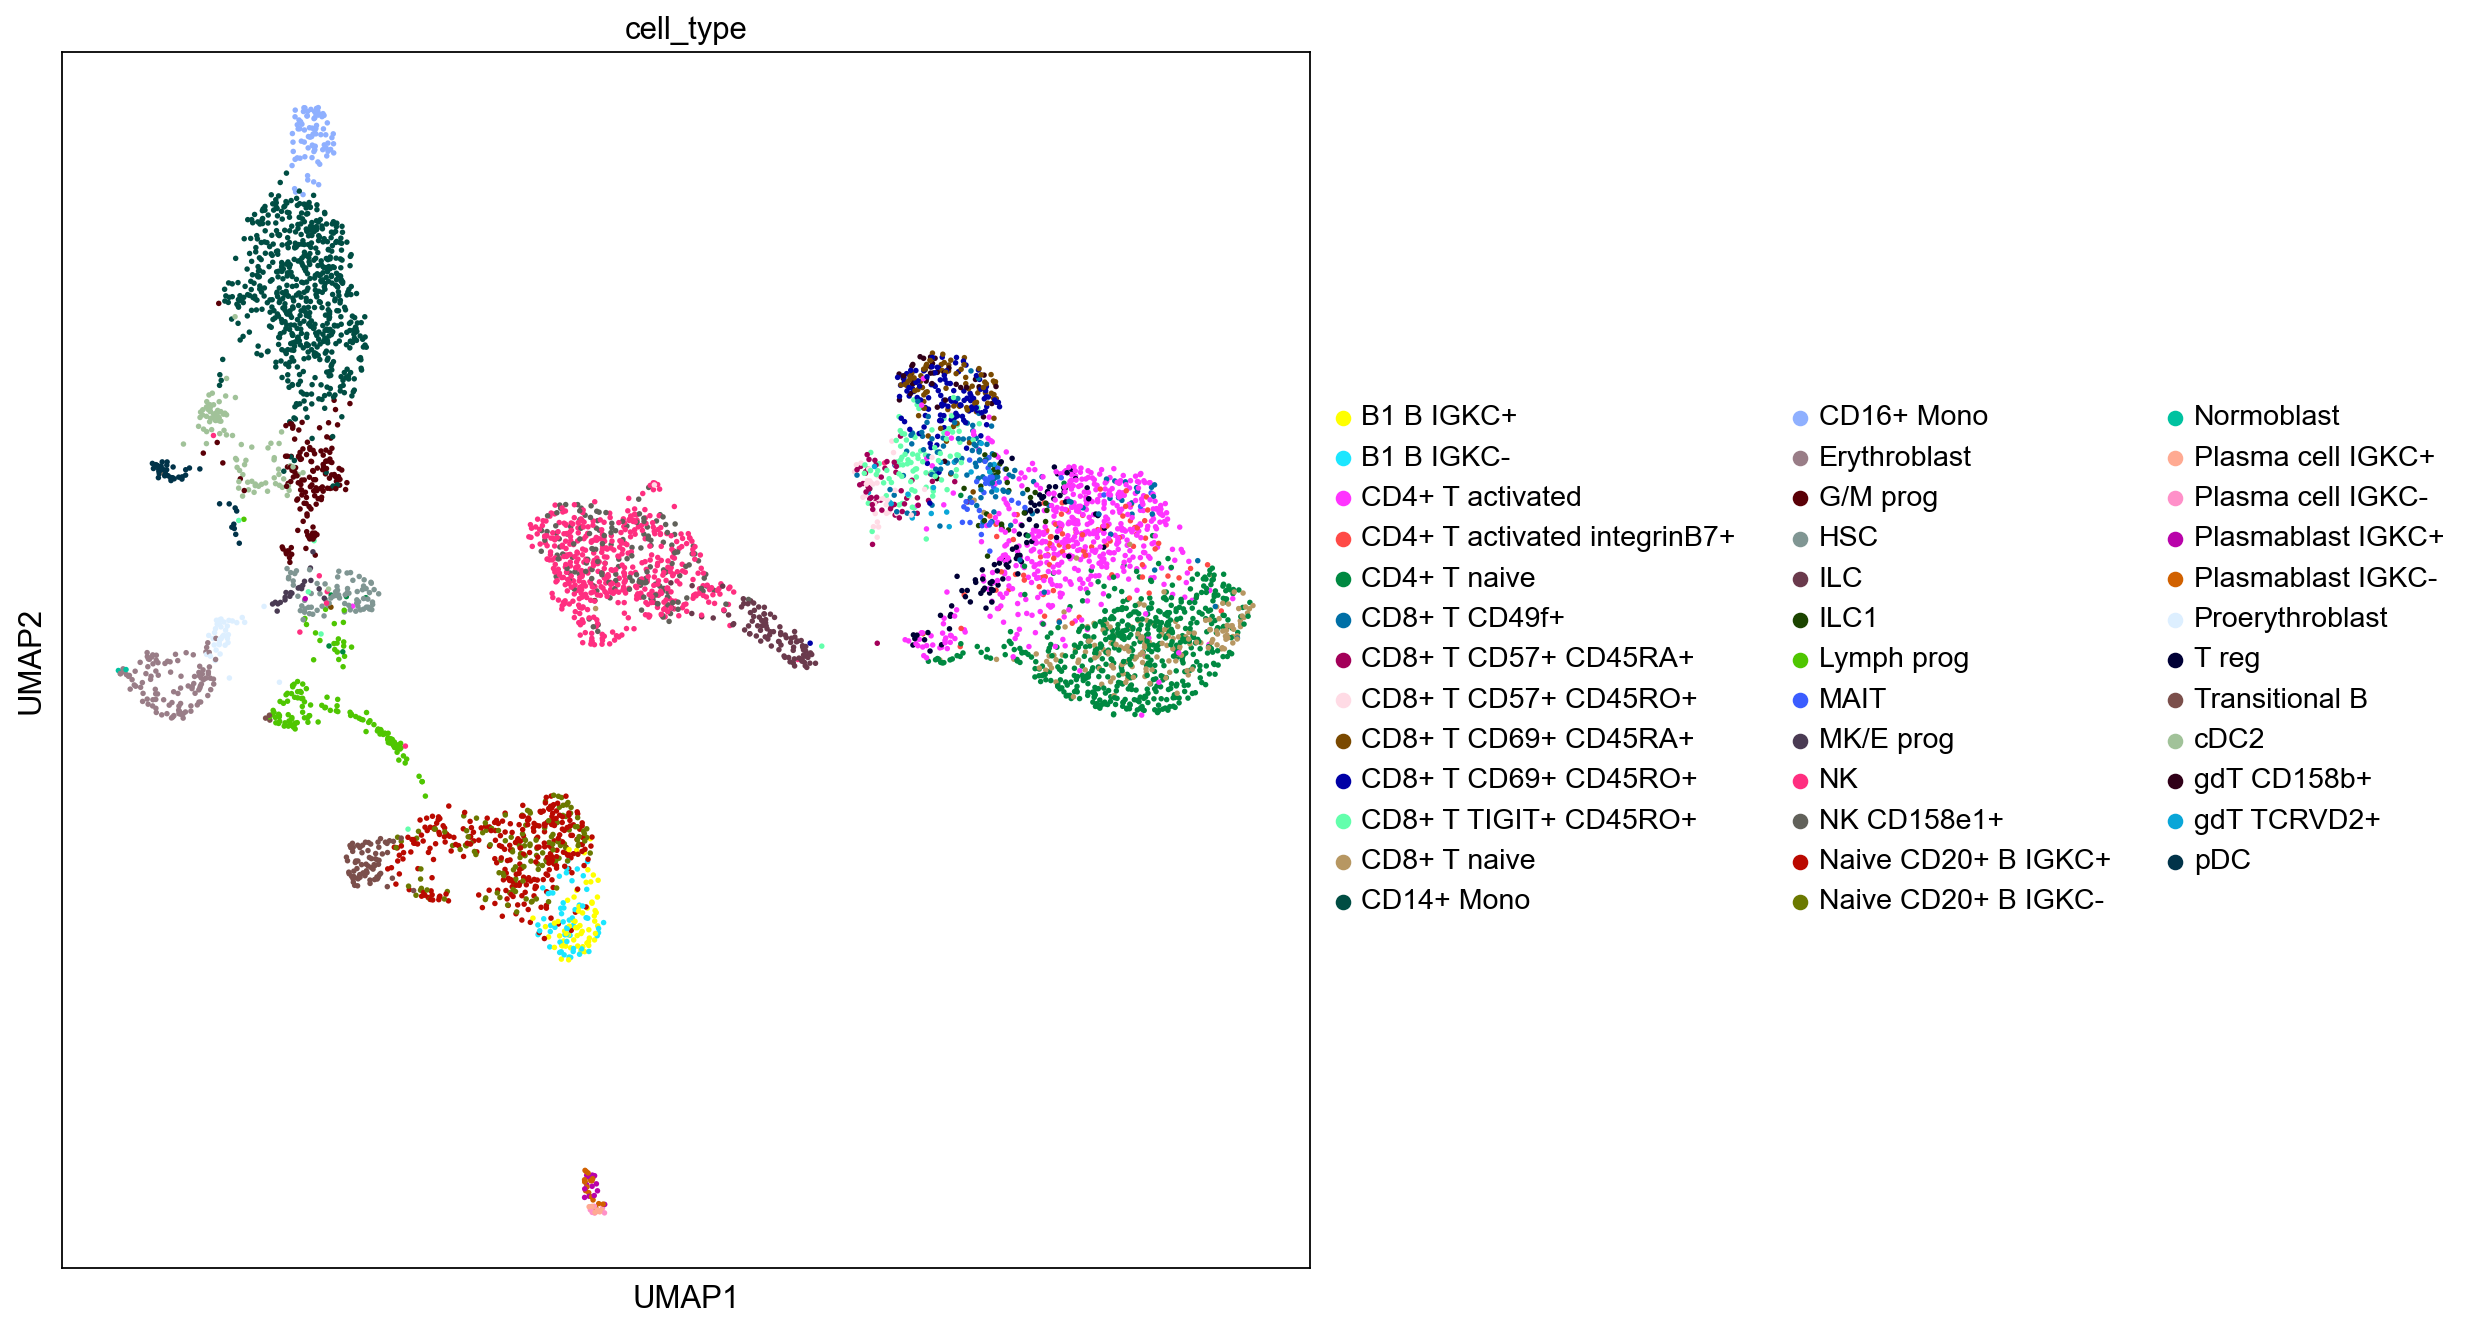

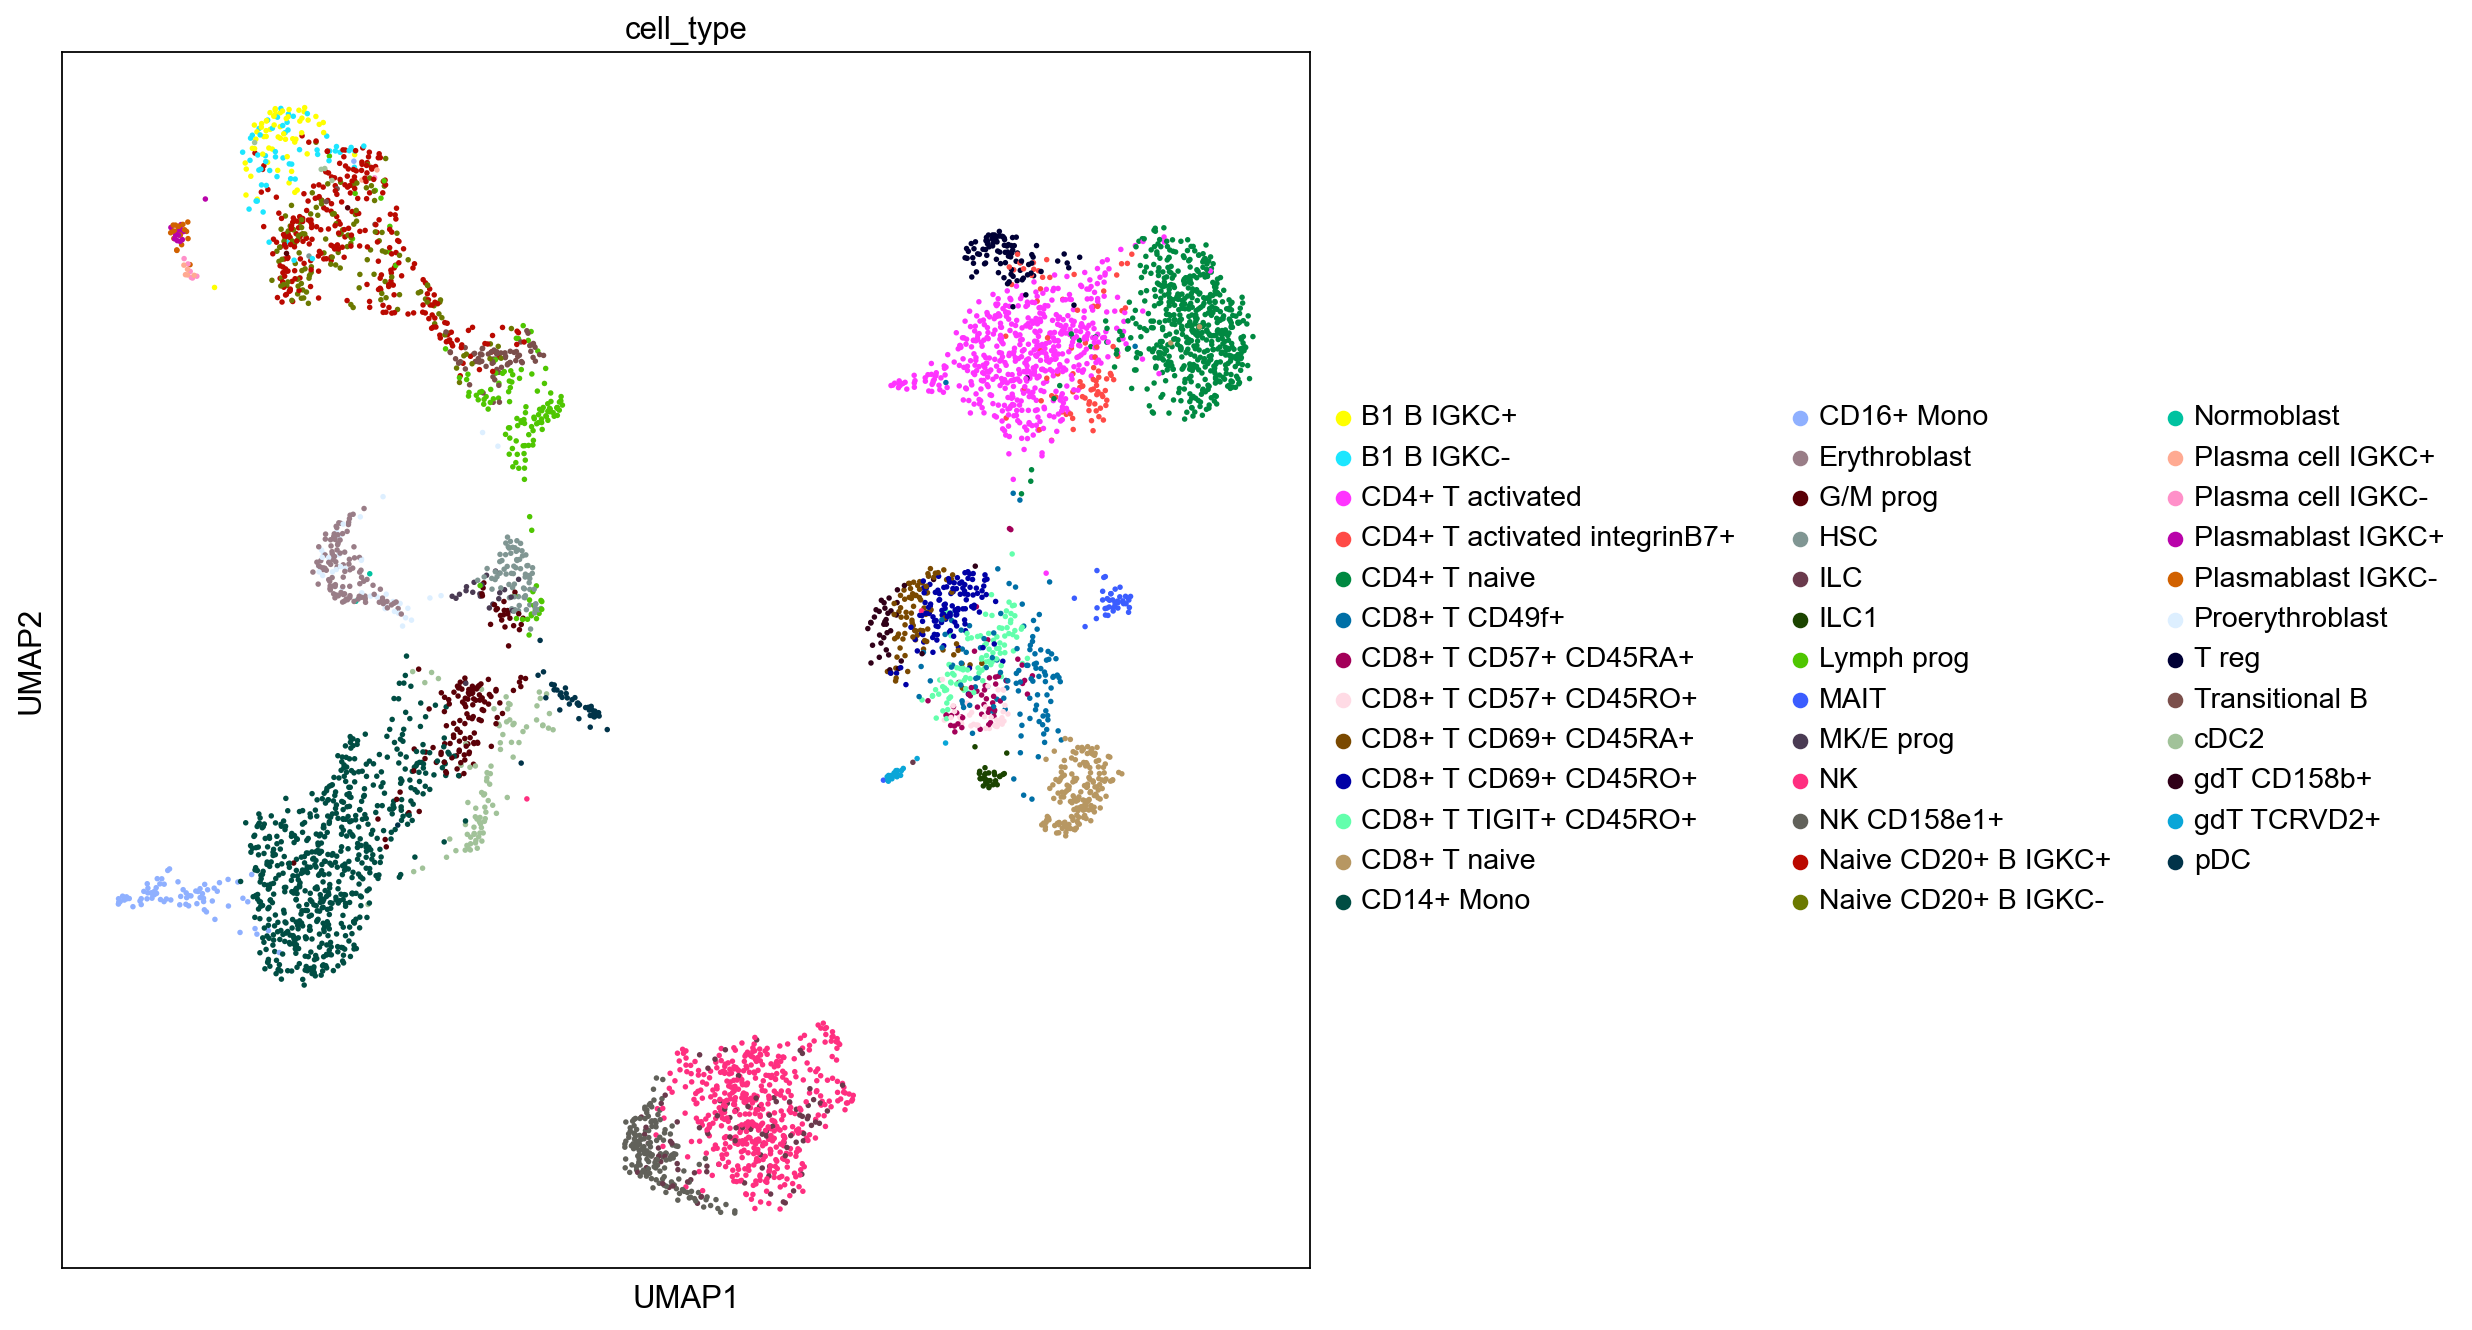

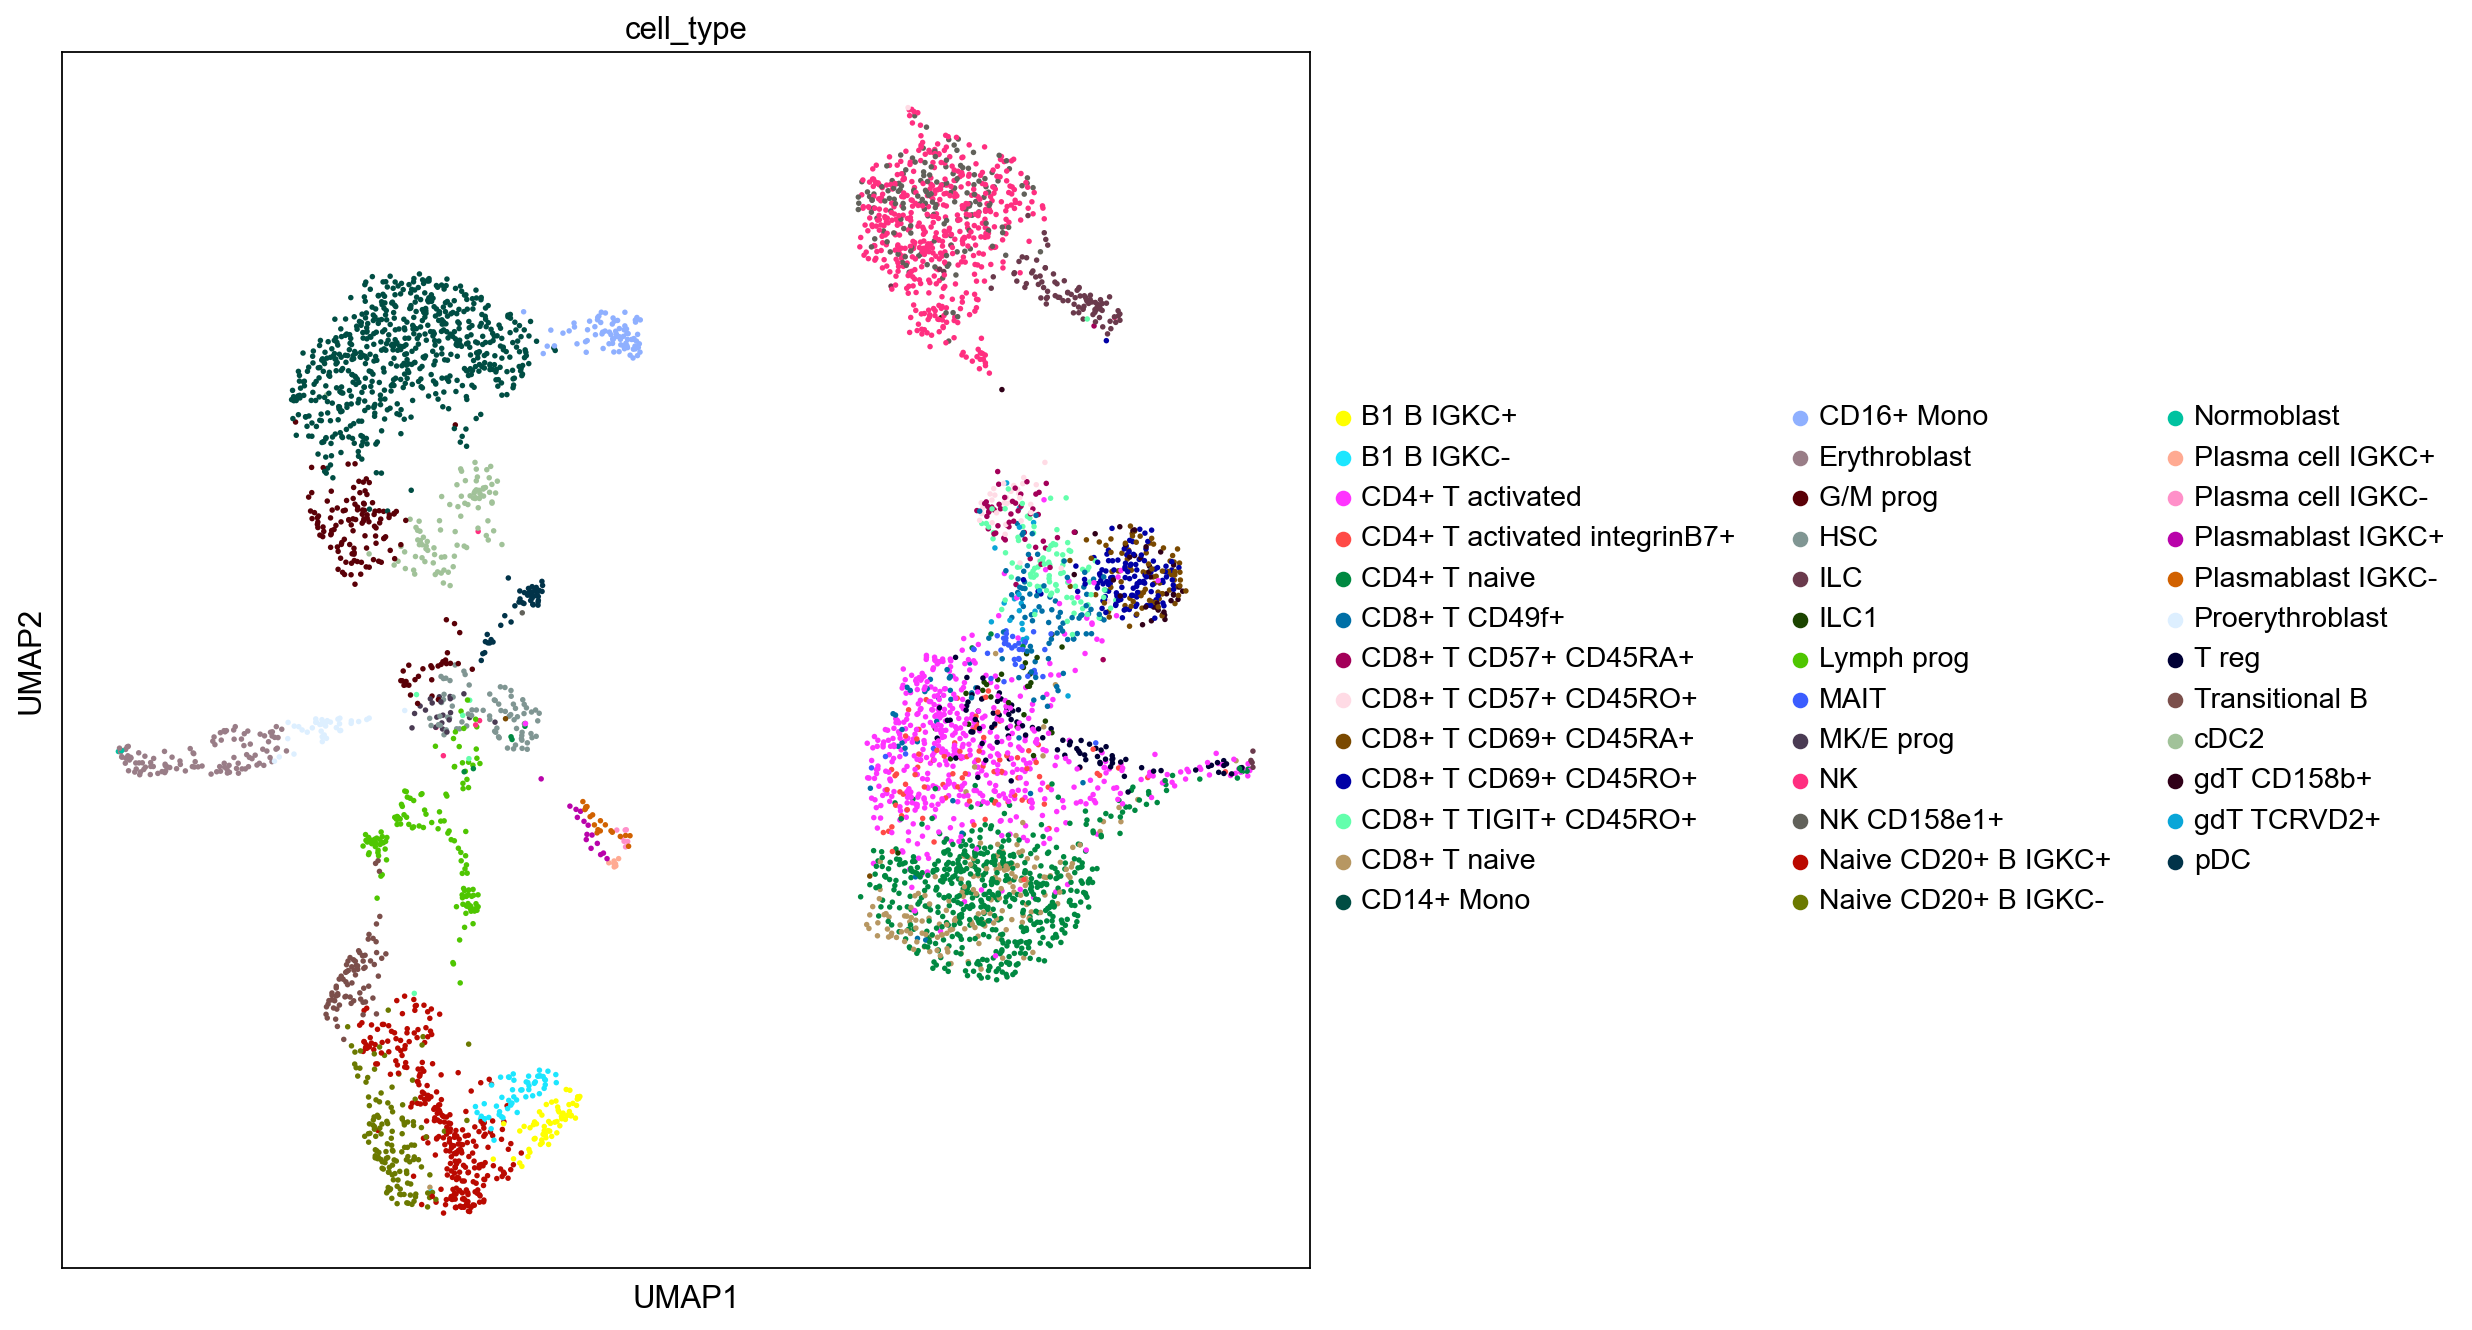

In [54]:
#Showing results in UMAPs

sc.set_figure_params(figsize=(10, 10))

sc.pl.umap(adata_latent, color=['cell_type'], ncols =3)
sc.pl.umap(adata_adt, color=['cell_type'], ncols =3)
sc.pl.umap(adata_gex, color=['cell_type'], ncols =3)

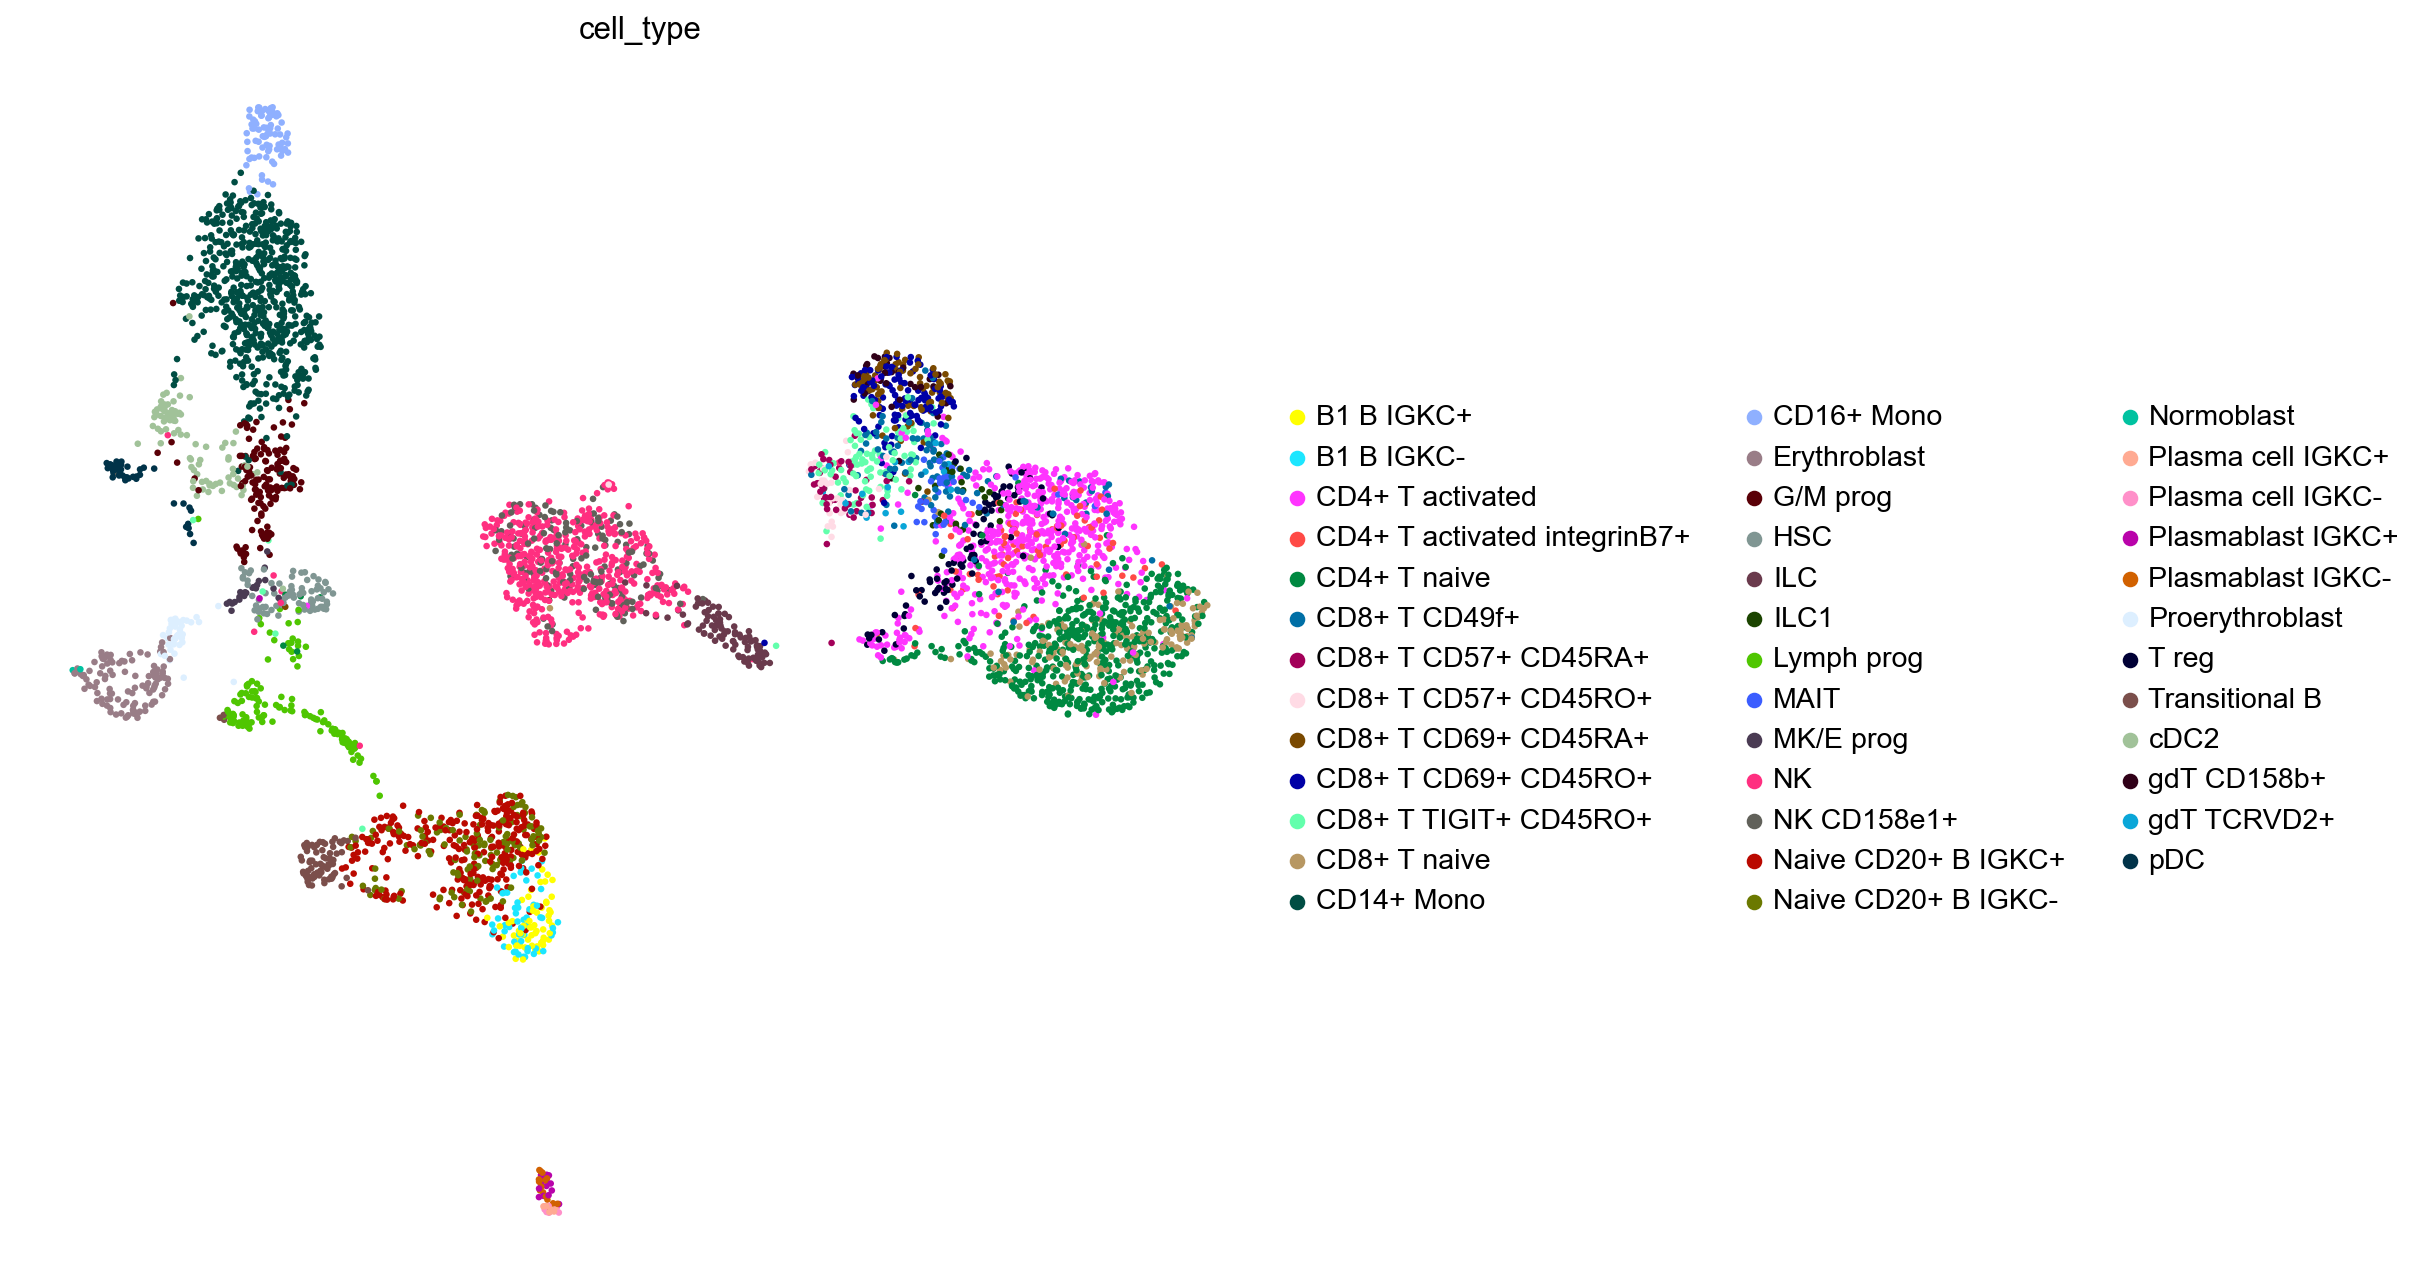

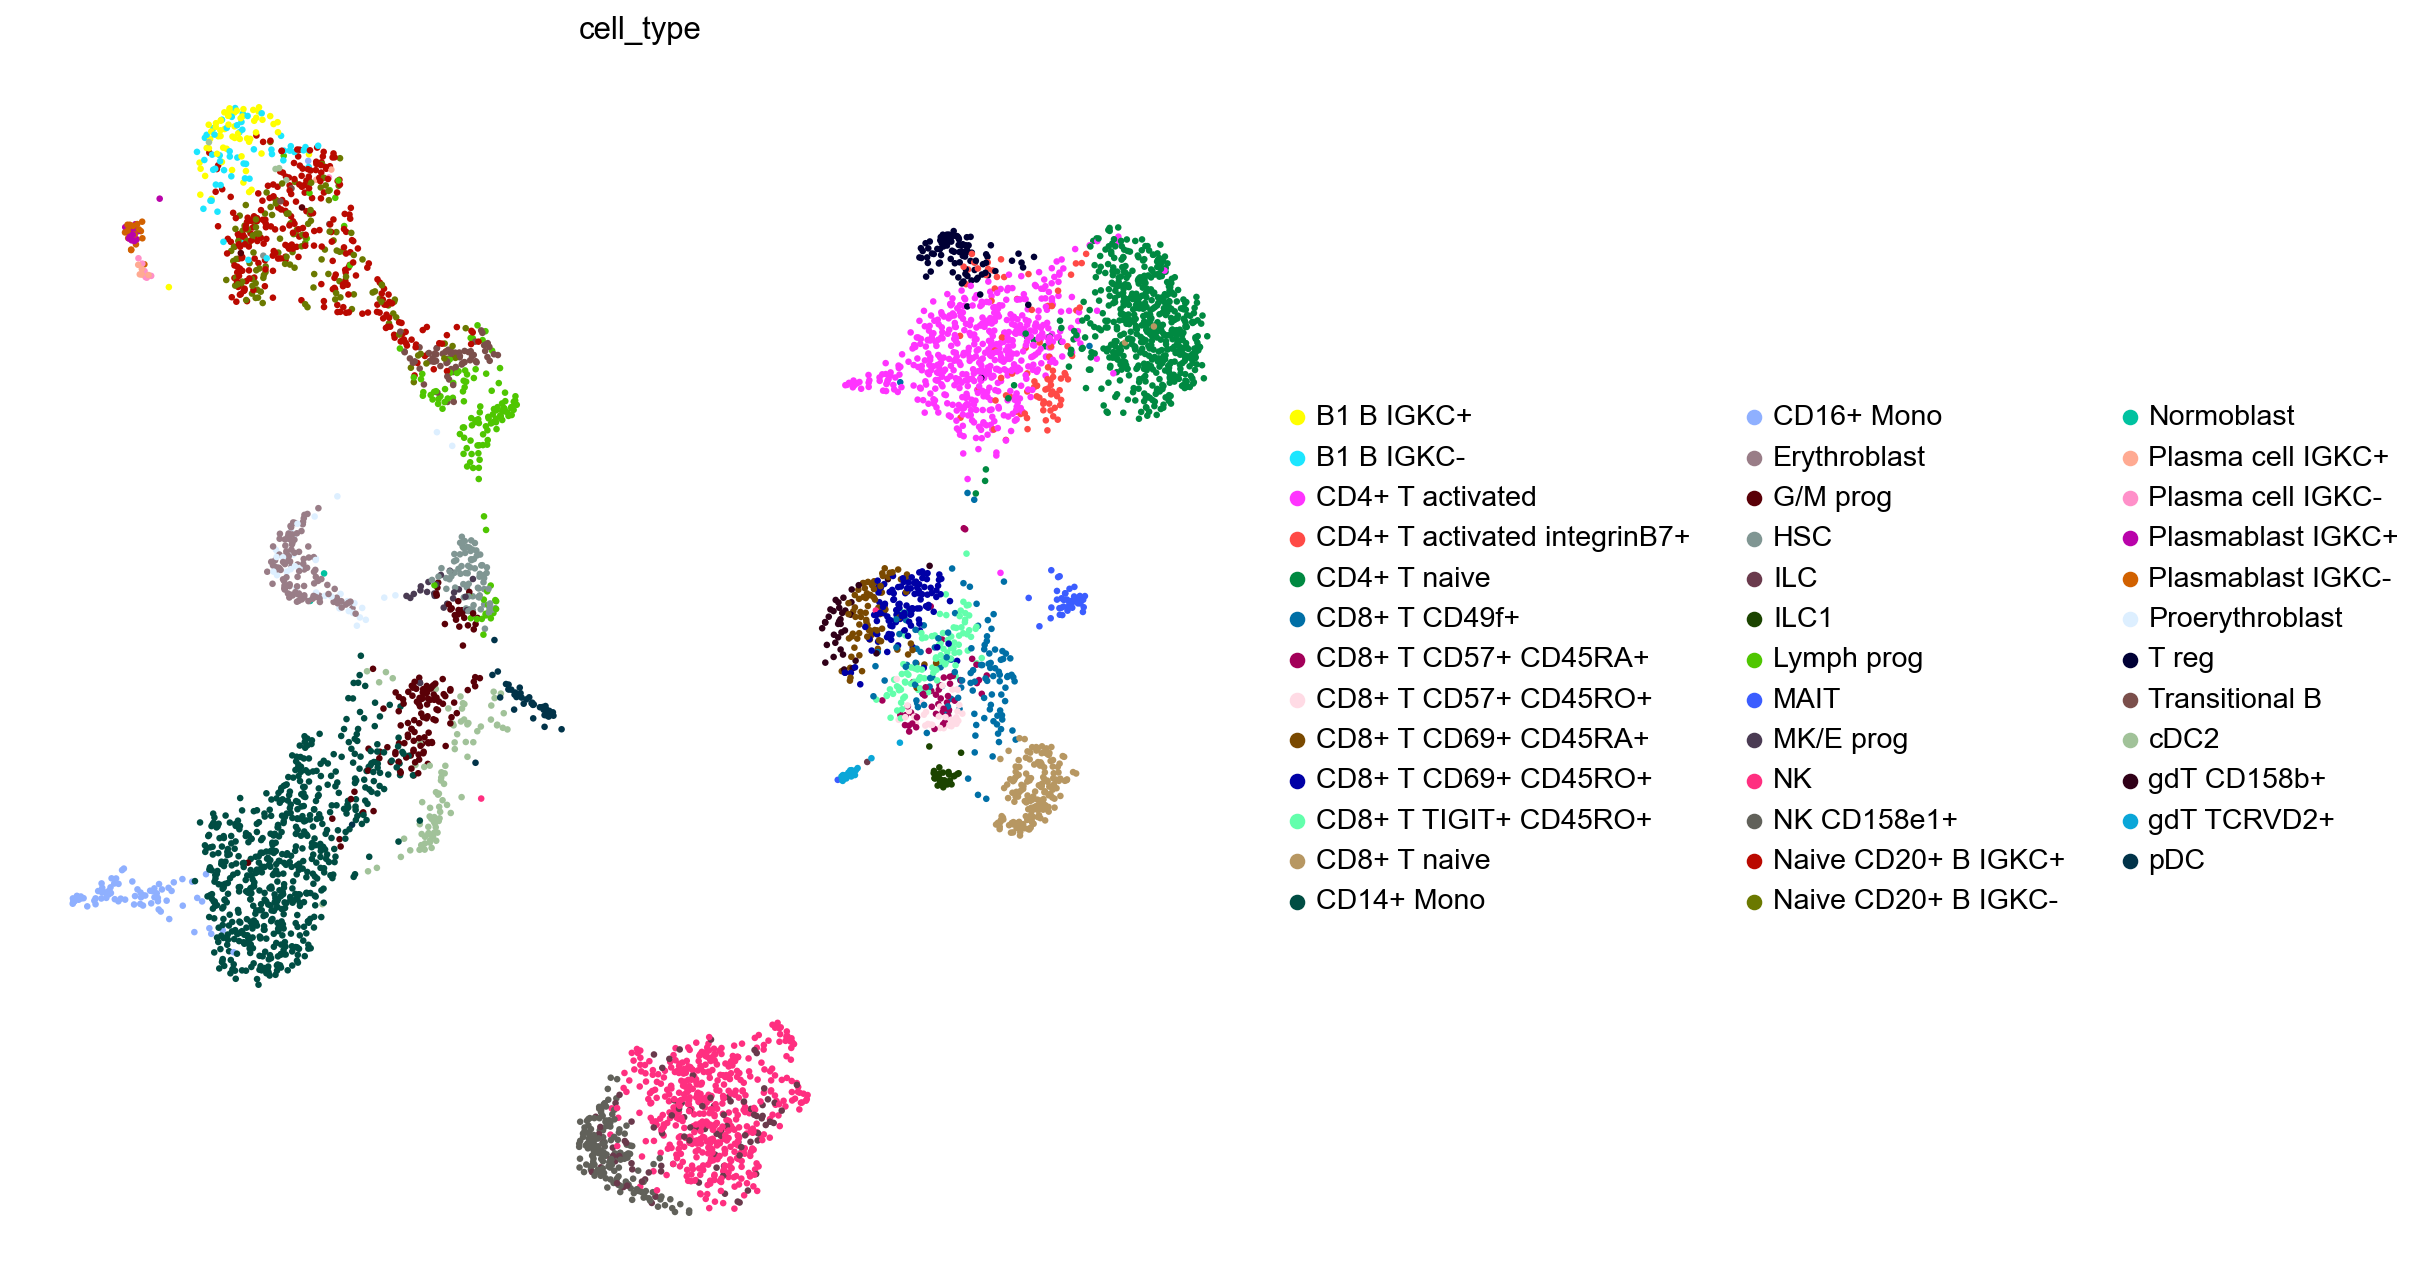

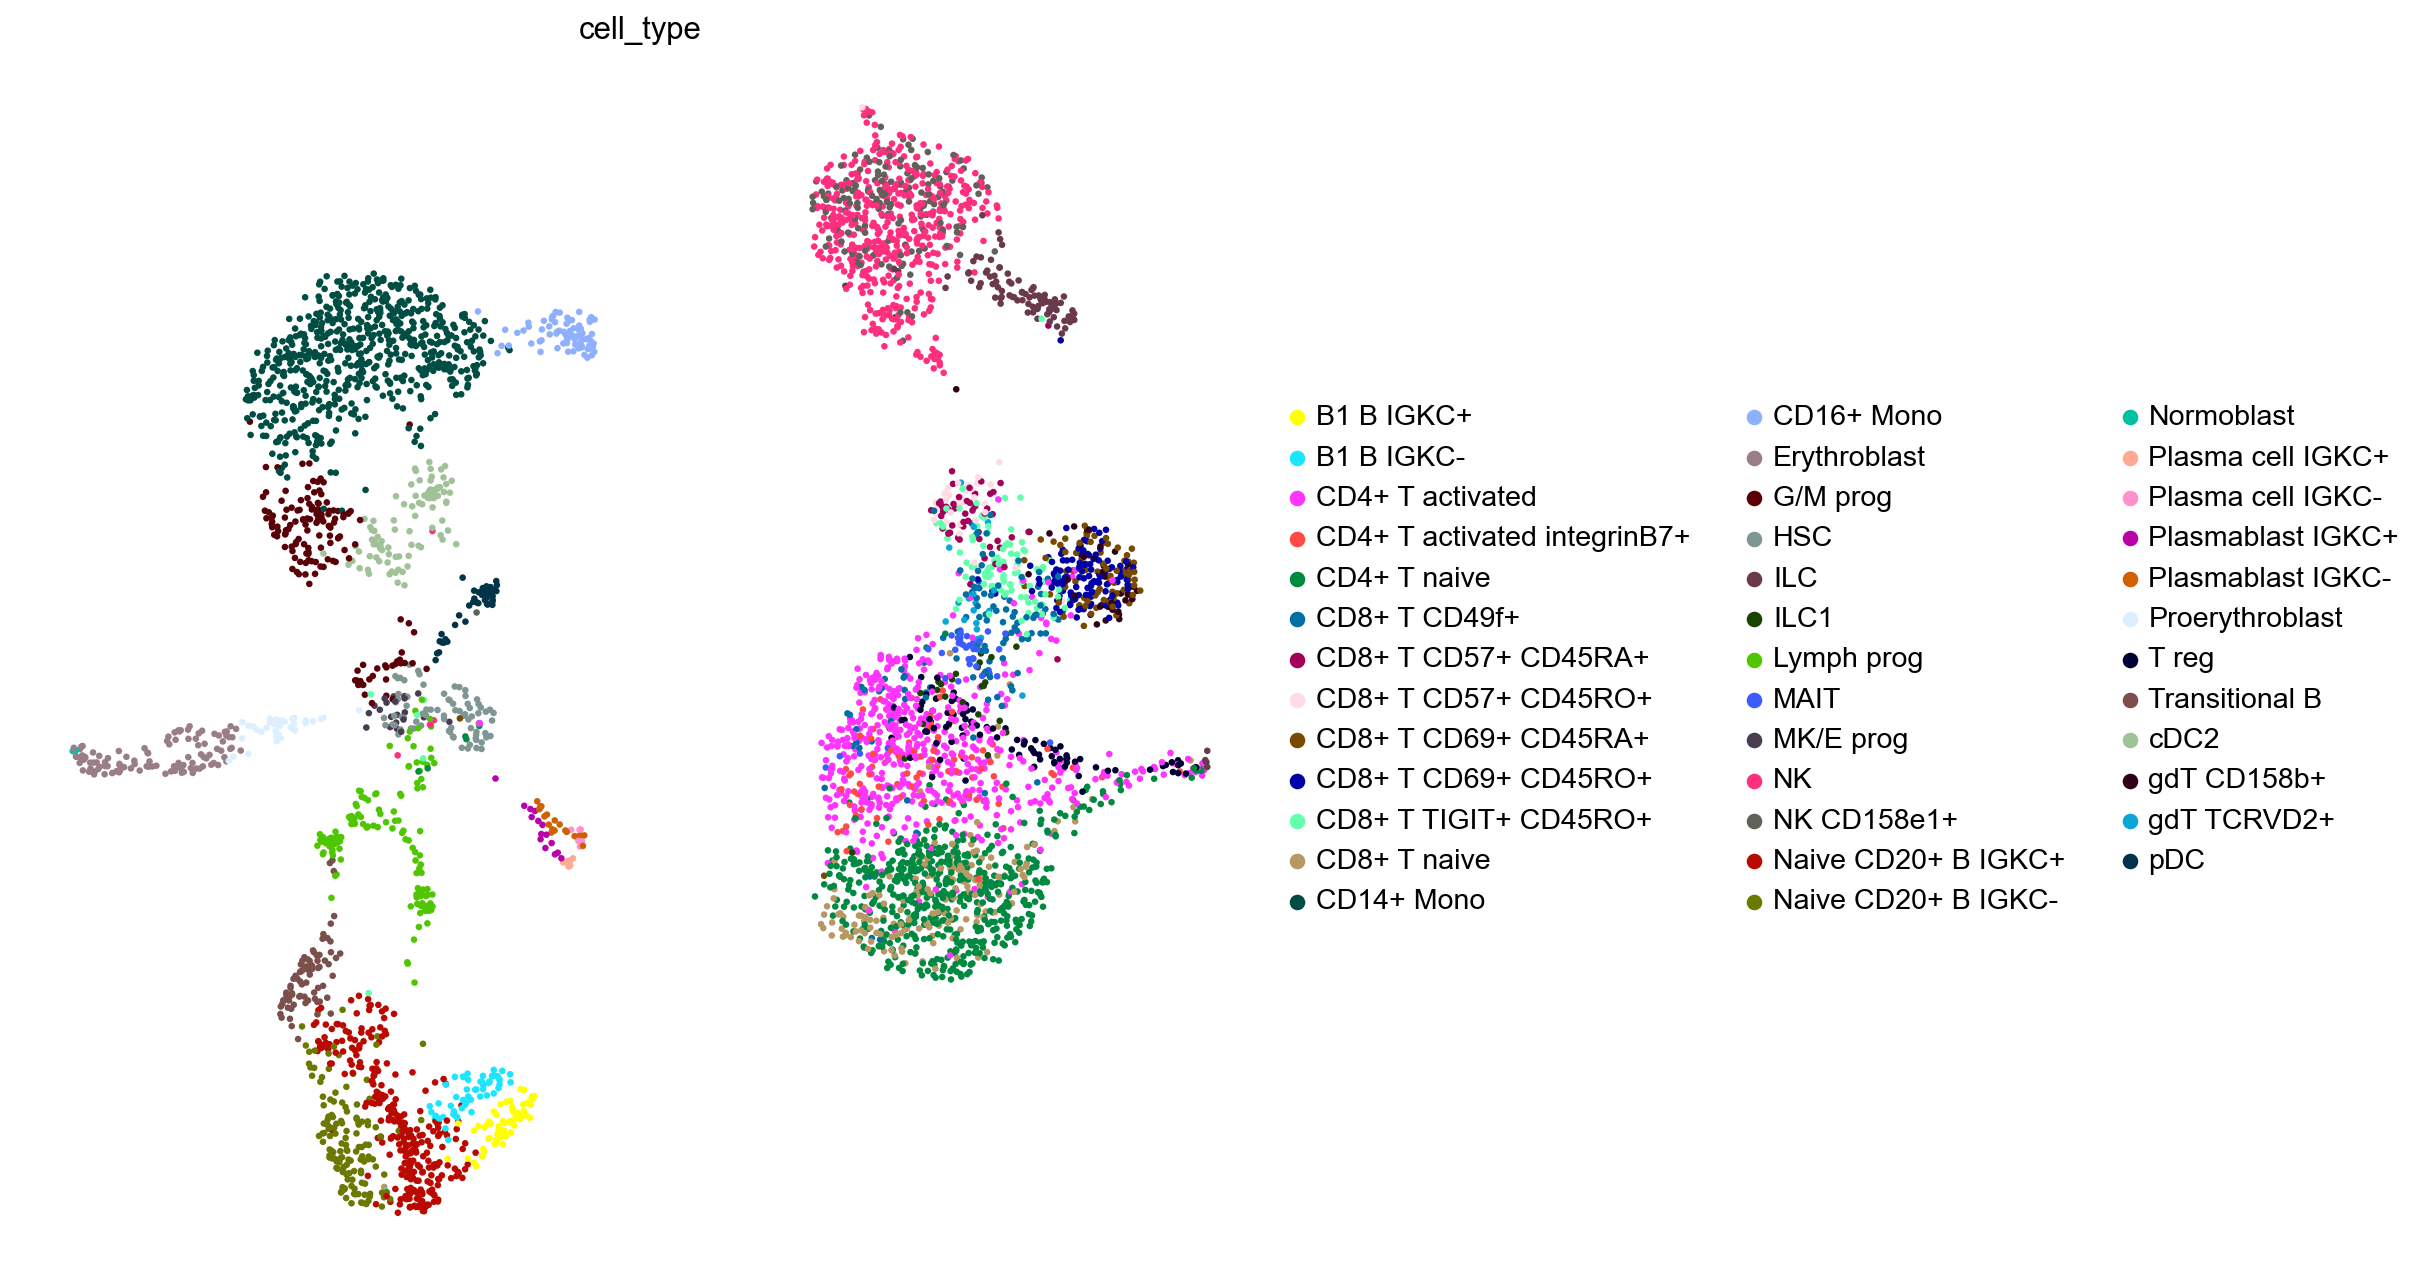

In [63]:
#Showing results in UMAPs

sc.set_figure_params(figsize=(10, 10))

sc.pl.umap(adata_latent, color=['cell_type'], ncols =3, frameon=False, size=35)
sc.pl.umap(adata_adt, color=['cell_type'], ncols =3, frameon=False, size=35)
sc.pl.umap(adata_gex, color=['cell_type'], ncols =3, frameon=False, size=35)

In [37]:
adata_latent1 = adata_latent.copy()

In [38]:
neurips_cell_type = adata_latent1.obs['cell_type'].unique().tolist

In [39]:
def replace_cell_type(x):
    if x not in ['ILC', 'gdT CD158b+']:
        return None
    return x

In [40]:
s = adata_latent1.obs.cell_type.apply(replace_cell_type)

adata_latent1.obs['selected_types'] = s

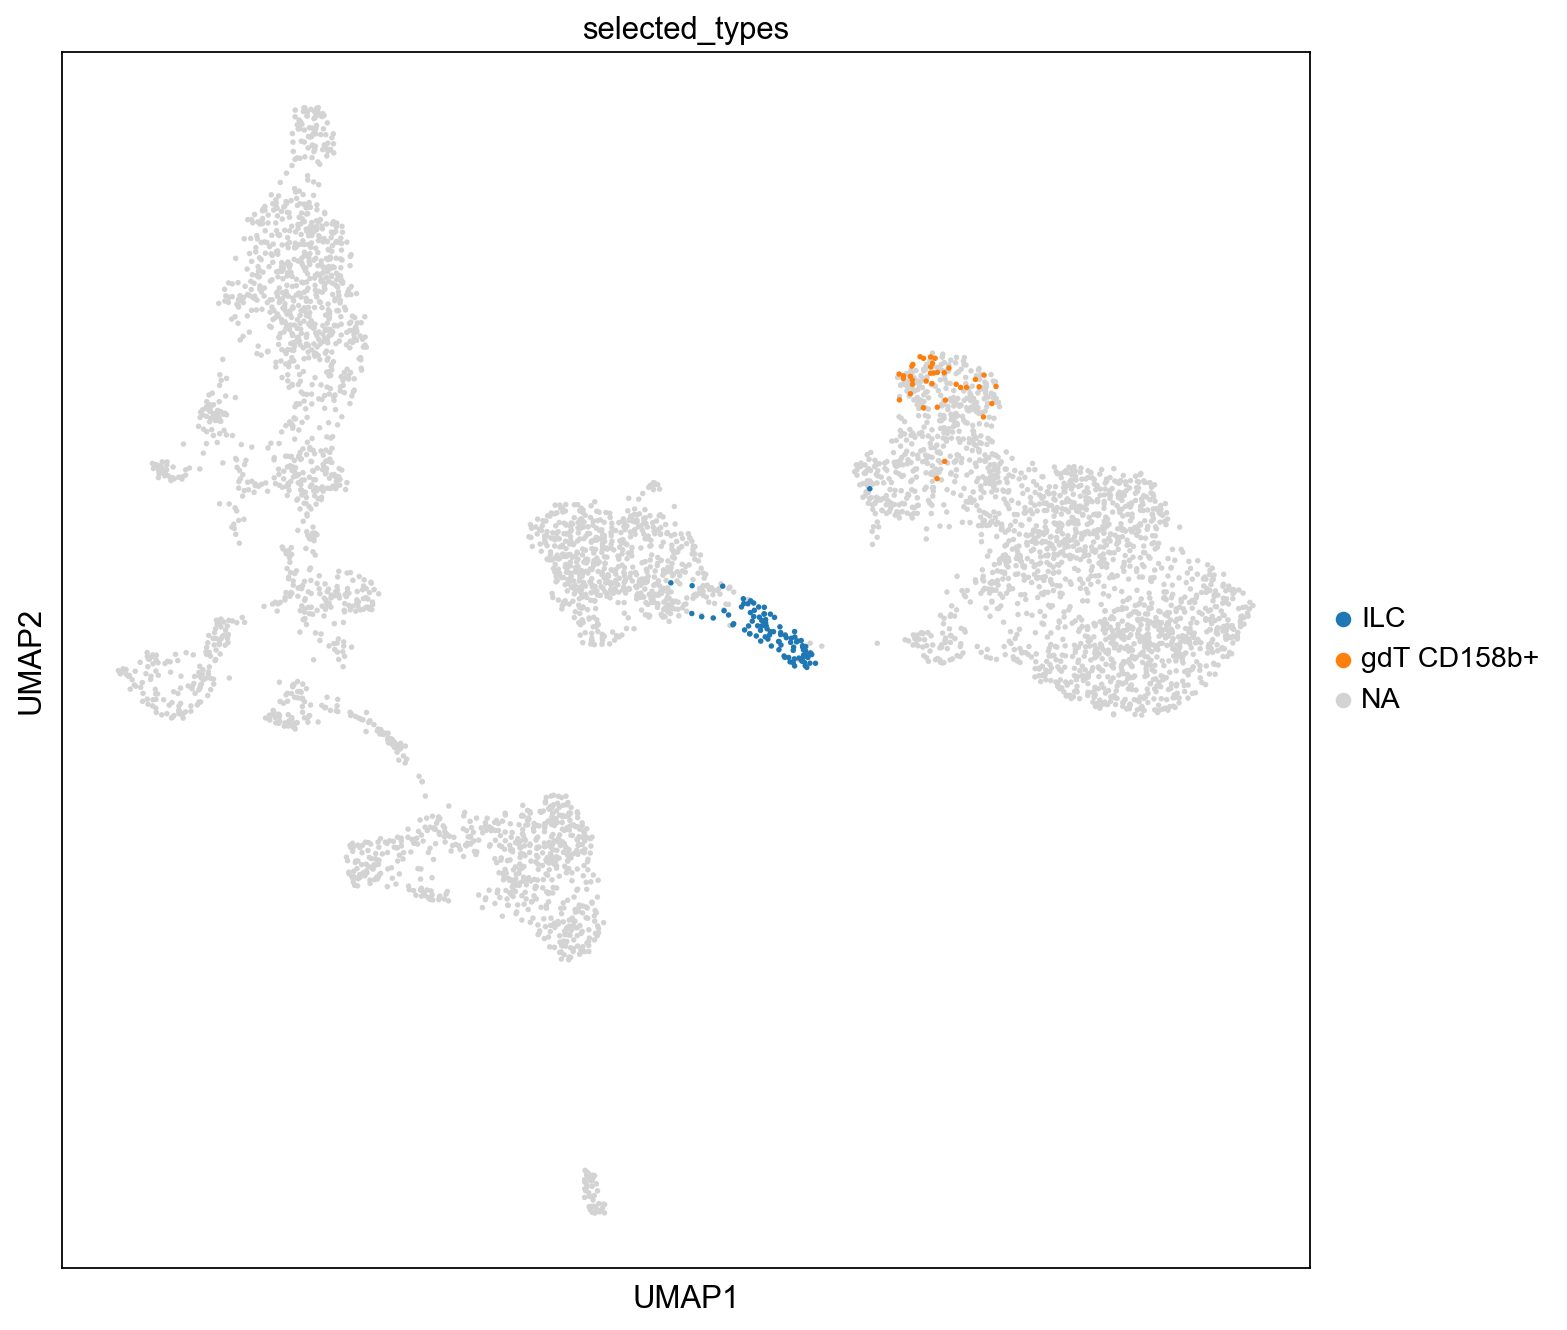

In [41]:
#Whole Neurips dataset plotted

sc.set_figure_params(figsize=(10, 10))

sc.pl.umap(adata_latent1, color = ['selected_types'])

In [42]:
adata_gex1 = adata_gex.copy()

In [43]:
s = adata_gex1.obs.cell_type.apply(replace_cell_type)

adata_gex1.obs['selected_types'] = s

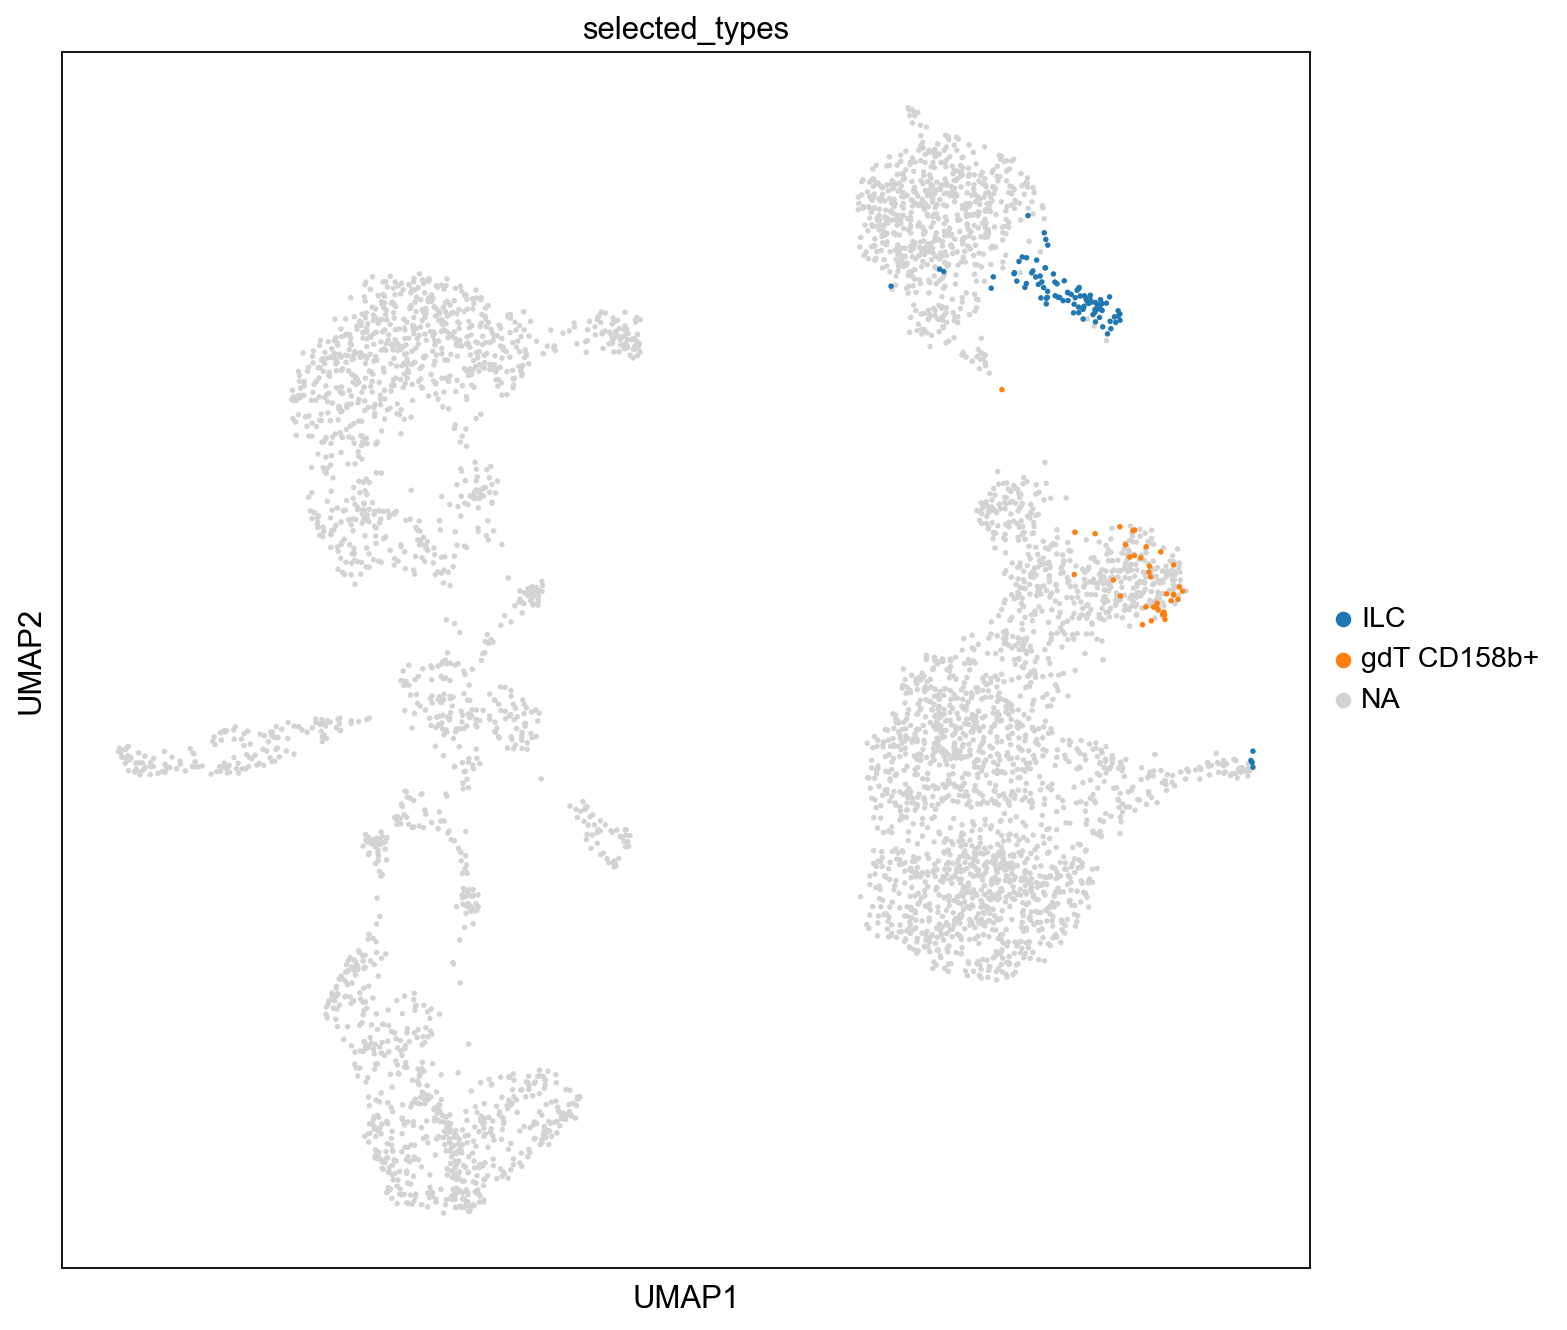

In [44]:
#Whole Neurips dataset plotted

sc.set_figure_params(figsize=(10, 10))

sc.pl.umap(adata_gex1, color = ['selected_types'])

In [45]:
adata_adt1 = adata_adt.copy()

In [46]:
adata_adt1.obs['selected_types'] = s

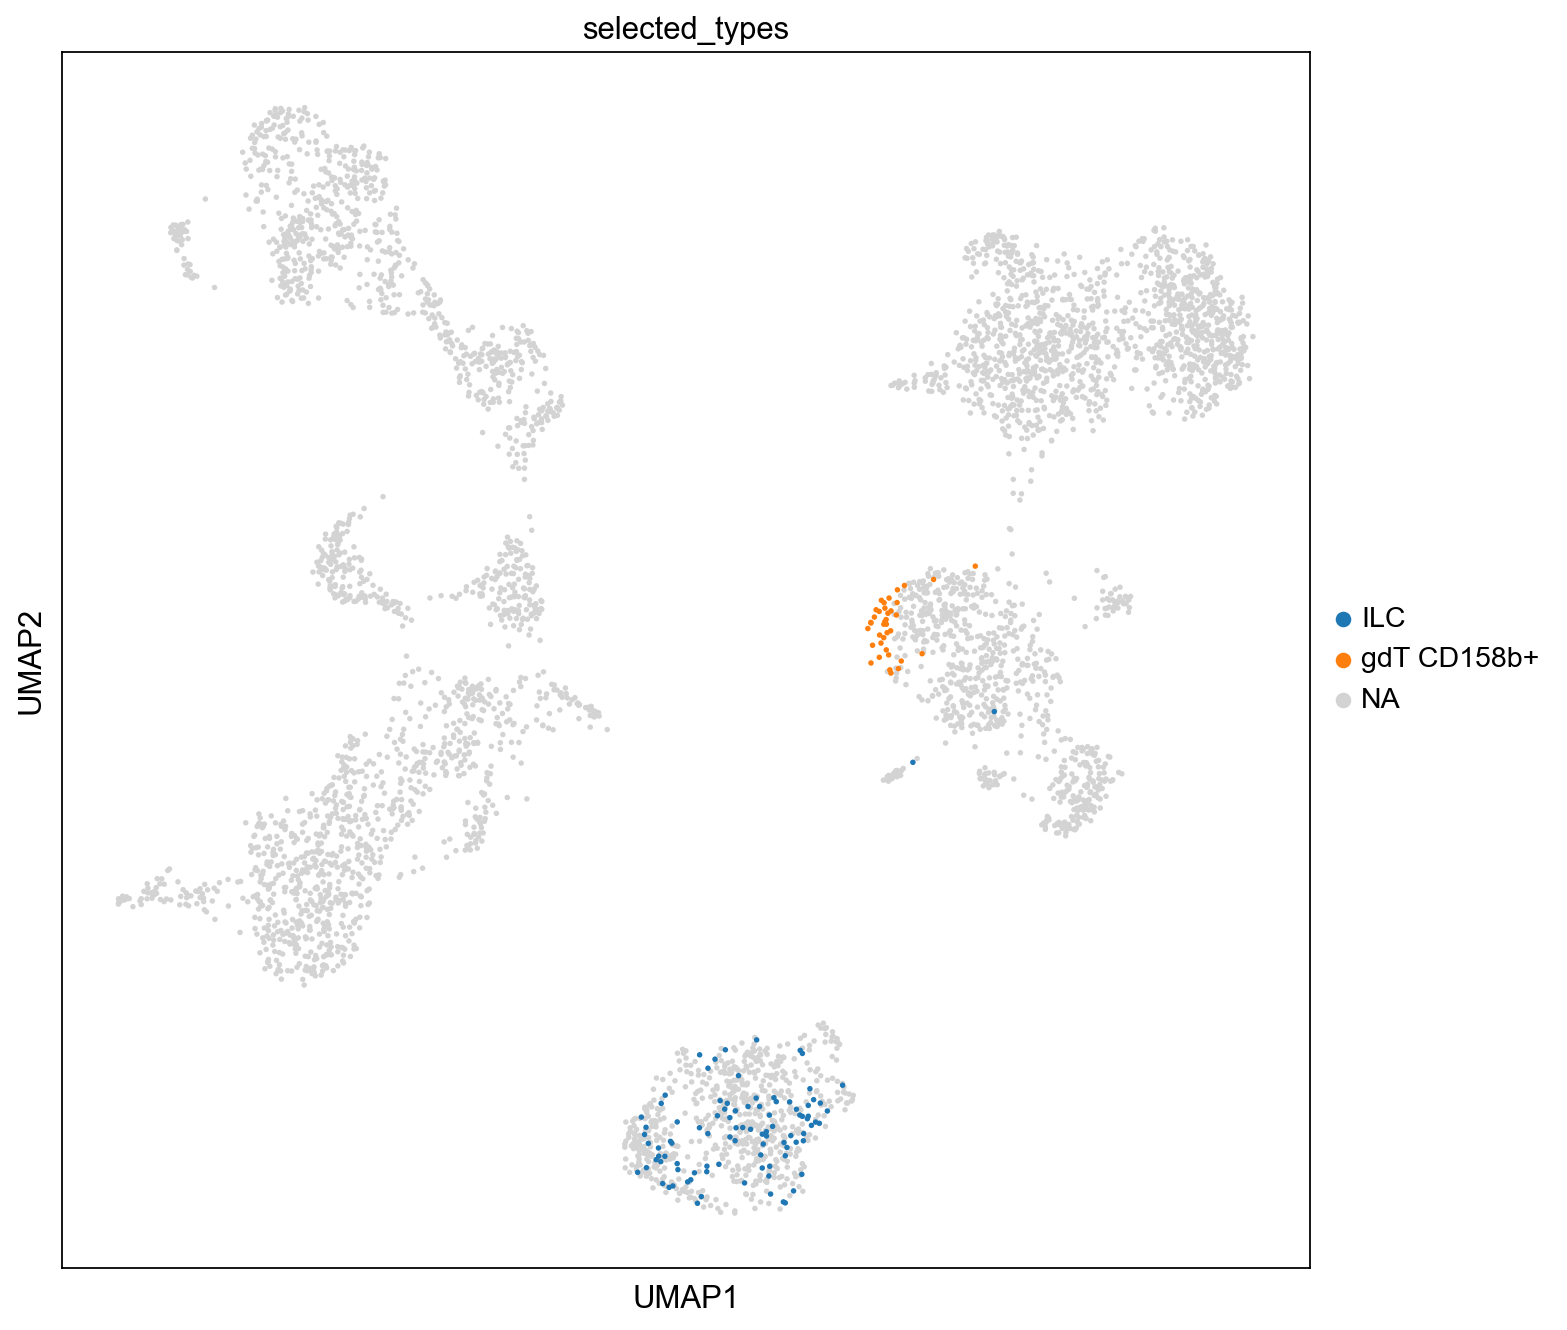

In [47]:
#Whole Neurips dataset plotted

sc.set_figure_params(figsize=(10, 10))

sc.pl.umap(adata_adt1, color = ['selected_types'])